## AlexNet Model Training Porocess

### Import libraries

In [1]:
import numpy as np
import keras
import tensorflow as tf
from matplotlib import pyplot as plt
from time import time
import warnings
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import os
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
%matplotlib inline

### Dataset paths

In [2]:
train_path = 'new_augmentation/train'
valid_path = 'new_augmentation/val'
test_path = 'new_augmentation/test'

### Training classes

In [3]:
train_classes = os.listdir(train_path)

### Training batch sizes

In [4]:
train_batch_size = 16
test_batch_size = 16
valid_batch_size = 16

### Training samples

In [5]:

# Count the number of samples in each directory
train_n = sum([len(files) for r, d, files in os.walk(train_path)])
test_n = sum([len(files) for r, d, files in os.walk(test_path)])
valid_n = sum([len(files) for r, d, files in os.walk(valid_path)])

print(f'Training samples: {train_n}')
print(f'Test samples: {test_n}')
print(f'Validation samples: {valid_n}')

Training samples: 1212
Test samples: 458
Validation samples: 457


In [6]:
train_n = 1212
test_n = 458
valid_n = 457

### Training steps (per epoch)

In [7]:
train_steps = train_n//train_batch_size
valid_steps = valid_n//valid_batch_size
test_steps = test_n//test_batch_size

### Epochs

In [8]:
epochs = 20

### Generate batches

In [9]:
train_batches = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(train_path, target_size=(128,128), classes=train_classes, batch_size=train_batch_size)
valid_batches = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(valid_path, target_size=(128,128), classes=train_classes, batch_size=valid_batch_size)
test_batches = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(test_path, target_size=(128,128), classes=train_classes, batch_size=test_batch_size)

Found 1212 images belonging to 9 classes.
Found 457 images belonging to 9 classes.
Found 458 images belonging to 9 classes.


### Base model (Efficientnet)

#### Transfer Learning

In [10]:
base_model = tf.keras.applications.VGG16(include_top=False,
    weights='imagenet',
    pooling='avg')

In [11]:
x = base_model.output
x = tf.keras.layers.Dense(512, activation='relu')(x)  # Add a dense layer with 512 units
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout for regularization
x = tf.keras.layers.Dense(256, activation='relu')(x)  # Add another dense layer with 256 units
x = tf.keras.layers.Dropout(0.5)(x)  # Add another dropout layer
output = tf.keras.layers.Dense(len(train_classes), activation='softmax')(x)  # Final output layer
new_model = tf.keras.Model(base_model.input, output)

### Set early stopping
Avoids model overfitting

In [12]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=2,
    mode='max',
    restore_best_weights=True
)

In [13]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9)

### Generate new model

In [14]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False,
    label_smoothing=0,
   reduction="none",
    name="categorical_crossentropy"), metrics=['accuracy'])

### Training

In [15]:
history = new_model.fit(train_batches, validation_data=valid_batches, validation_steps=valid_steps, steps_per_epoch=train_steps, epochs=epochs,callbacks=[es_callback])

Epoch 1/20
75/75 [==============================] - 649s 9s/step - loss: 2.4478 - accuracy: 0.1371 - val_loss: 2.2214 - val_accuracy: 0.0714
Epoch 2/20
75/75 [==============================] - 615s 8s/step - loss: 2.1658 - accuracy: 0.1455 - val_loss: 2.1955 - val_accuracy: 0.0469
Epoch 3/20
49/75 [==================>...........] - ETA: 3:14 - loss: 2.1093 - accuracy: 0.1747

KeyboardInterrupt: 

### Evaluate training process

In [16]:
results = new_model.evaluate(train_batches,  steps=train_steps)
results

75/75 [==============================] - 61s 803ms/step - loss: 0.4241 - accuracy: 0.9108


[0.42405882477760315, 0.9108333587646484]

#### Loss function

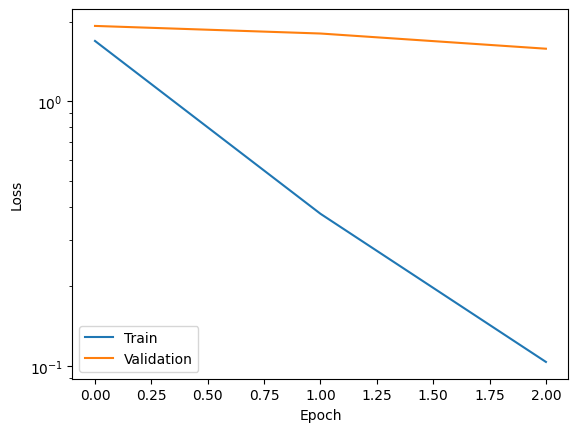

In [17]:
plt.semilogy(history.epoch,  history.history['loss'], label='Train')
plt.semilogy(history.epoch,  history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Accuracy function

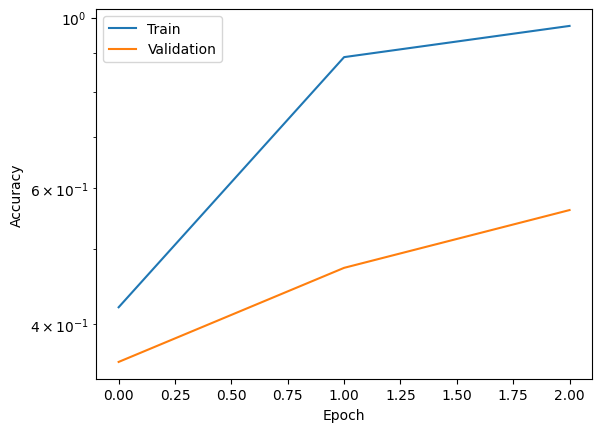

In [18]:
plt.semilogy(history.epoch, history.history['accuracy'], label='Train')
plt.semilogy(history.epoch, history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
Y_train_pred =new_model.predict(train_batches,train_steps)

76/76 [==============================] - 80s 1s/step


In [20]:
y_train_pred = np.argmax(Y_train_pred, axis=1)

In [21]:
print(len(train_batches.classes))
print(len(y_train_pred))

1212
1212


#### Confusion matrix

In [22]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming train_batches is your training data generator
# Make predictions on the training set
y_train_pred = new_model.predict(train_batches, steps=train_batches.samples // train_batches.batch_size + 1)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

# Ensure the lengths match
assert len(train_batches.classes) == len(y_train_pred_classes), "Mismatch in number of samples"

# Compute the confusion matrix
cm_train = confusion_matrix(train_batches.classes, y_train_pred_classes)

print(cm_train)

# cm_train = confusion_matrix(train_batches.classes, y_train_pred)

76/76 [==============================] - 88s 1s/step
[[33 34 25 20  5 36 24 14  9]
 [37 36 21 19  8 34 23 17  7]
 [21 16 14  4  6 13 15 10  3]
 [21 21 12  7  2 12 14  7  6]
 [10  9  6  5  3  6  8  4  0]
 [44 25 30 16  5 32 22 18  9]
 [19 29 24 14  6 24 23  9  5]
 [16 16 16  8  3 13 11 12  6]
 [21 23 14  7  3  5 18  5  4]]


Text(0.5, 135.7222222222222, 'Predicted label')

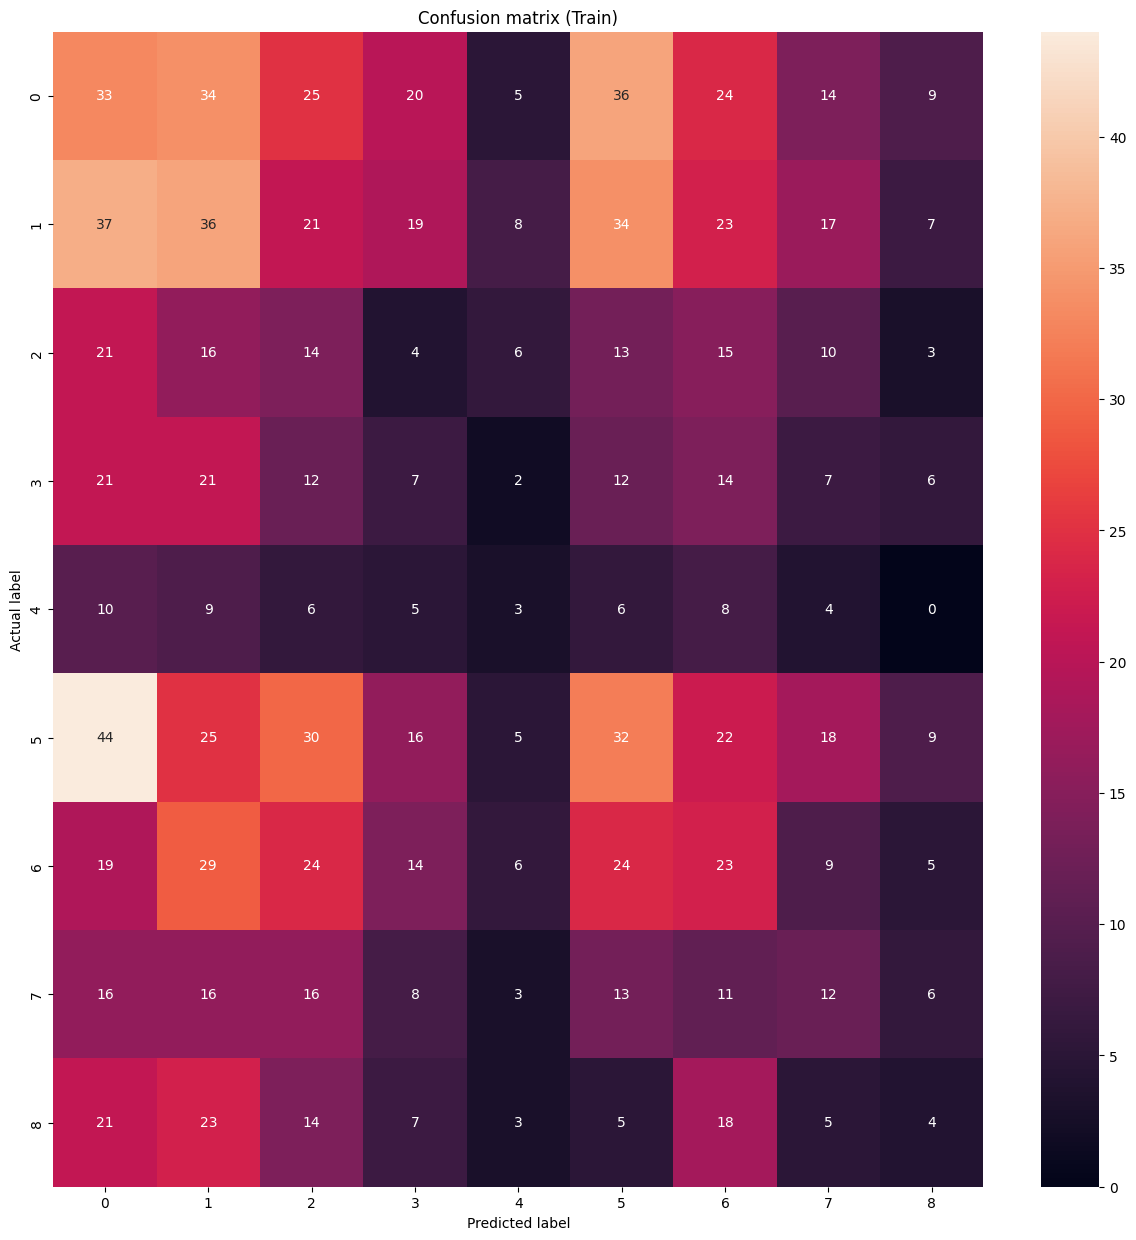

In [23]:
plt.figure(figsize=(15,15))
sns.heatmap(cm_train, annot=True, fmt="d")
plt.title('Confusion matrix (Train)')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Model testing

In [24]:
Y_pred =new_model.predict(test_batches,test_steps)

29/29 [==============================] - 27s 890ms/step


In [25]:
y_pred = np.argmax(Y_pred, axis=1)

In [26]:
# cm = confusion_matrix(test_batches.classes, y_pred)

from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming test_batches is your test data generator
# Make predictions on the test set
y_pred = new_model.predict(test_batches, steps=test_batches.samples // test_batches.batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure the lengths match
assert len(test_batches.classes) == len(y_pred_classes), "Mismatch in number of samples"

# Compute the confusion matrix
cm = confusion_matrix(test_batches.classes, y_pred_classes)

print(cm)

29/29 [==============================] - 27s 917ms/step
[[18  9 13  0  0  4  5  0  2]
 [20  6 14  0  1  2  6  0  2]
 [17  5 20  0  0  5  2  1  1]
 [16  8 19  1  0  3  2  0  2]
 [23  6 14  1  0  4  2  0  1]
 [23  4 14  0  0  4  6  0  0]
 [20  1 18  0  0  6  4  0  2]
 [22  3 12  1  0  6  4  0  2]
 [20  8 14  0  0  2  4  1  2]]


Text(0.5, 135.7222222222222, 'Predicted label')

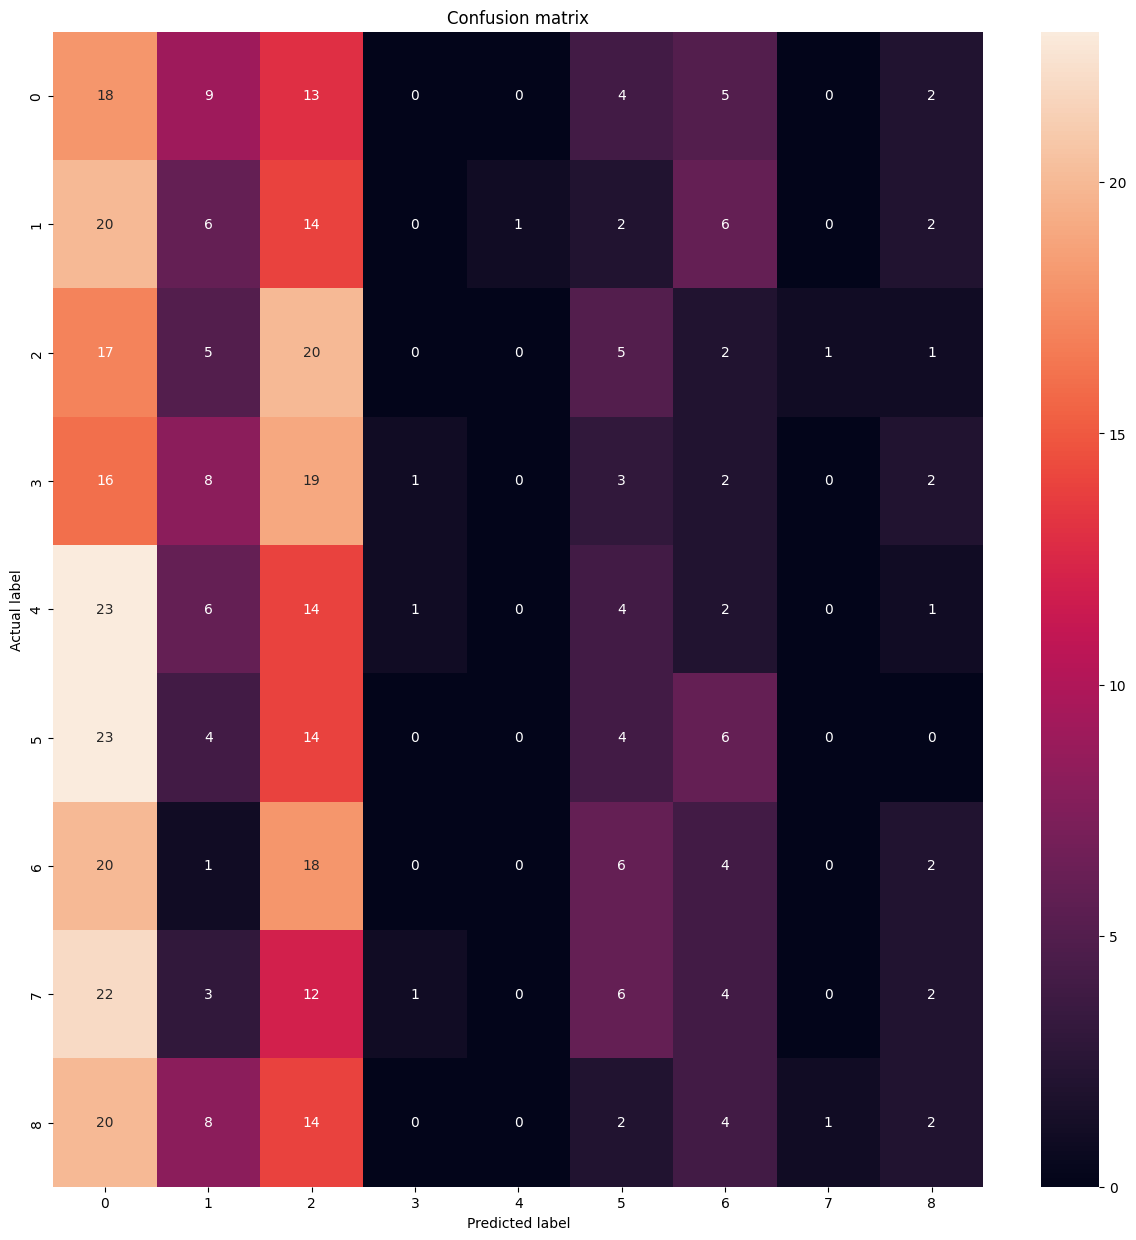

In [27]:
plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Evaluate model on test set

In [28]:
test_loss, test_accuracy = new_model.evaluate(test_batches, steps=test_steps)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

28/28 [==============================] - 32s 1s/step - loss: 2.5894 - accuracy: 0.2969
Test Loss: 2.589380979537964, Test Accuracy: 0.296875


Evaluation Matrix

In [29]:
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred = new_model.predict(test_batches, steps=test_batches.samples // test_batches.batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure the lengths match
assert len(test_batches.classes) == len(y_pred_classes), "Mismatch in number of samples"

# Generate classification report
report = classification_report(test_batches.classes, y_pred_classes, target_names=test_batches.class_indices.keys())
print(report)

29/29 [==============================] - 38s 1s/step
              precision    recall  f1-score   support

   Duryodhan       0.10      0.35      0.16        51
       Ganga       0.12      0.12      0.12        51
        Lali       0.09      0.24      0.13        51
  Parashuram       0.00      0.00      0.00        51
        Raju       1.00      0.02      0.04        51
Sivilbahadur       0.17      0.12      0.14        51
        Sonu       0.03      0.02      0.02        51
   Tirathram       0.50      0.02      0.04        50
    Yoglaxmi       0.00      0.00      0.00        51

    accuracy                           0.10       458
   macro avg       0.22      0.10      0.07       458
weighted avg       0.22      0.10      0.07       458



### Save model

In [30]:
new_model.save('vgg16_new')

INFO:tensorflow:Assets written to: restnet50v4_new\assets


INFO:tensorflow:Assets written to: restnet50v4_new\assets
